# BDT - Background and Signal distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import math

signal_all = pd.DataFrame()
signal_mass = [300, 420, 440, 460, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 2000]
for each in signal_mass:
    df_temp = pd.read_csv(str(each) + ".csv", index_col=0)
    df_temp["mass"] = each
    df_temp.drop(columns=["nTags", "MCChannelNumber", "mVHres"], inplace=True)
    signal_all = pd.concat([df_temp, signal_all], ignore_index=True)

signal_one = pd.read_csv('500.csv', index_col=0)
signal_one.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)
    
background = pd.read_csv("background.csv", index_col=0)
background.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)

background = background[background["weight"]>0 ] #Only positive Bkg Weight

#### train_test_split on signals and bkg separately:

In [2]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2) #splitting bkg into train and test
train_signal, test_signal = train_test_split(signal_all, test_size=0.4, random_state=2) #splitting signal into train and test 

#### Reweighting signals so they are all equal

In [3]:
val_bkg, test_bkg = train_test_split(test_bkg, test_size=0.5, random_state=2)
val_signal, test_signal = train_test_split(test_signal, test_size=0.5, random_state=2)

train_bkg.loc[:, "weight"] = np.abs(train_bkg["weight"])
val_bkg.loc[:, "weight"] = np.abs(val_bkg["weight"])
train_signal.loc[:, "weight"] = np.sum(train_bkg["weight"])/np.sum(train_signal["weight"])
for each in signal_mass:
        val_signal.loc[val_signal["mass"]==each].loc[:, "weight"] = np.sum(val_bkg["weight"])/np.sum(val_signal.loc[val_signal["mass"]==each]["weight"])/len(signal_mass)

/opt/jupyterhub/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/jupyterhub/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Change the weights of training signal so the sum is the same as that of bkg:

In [4]:
train_signal_weight = train_signal["weight"] * np.sum(train_bkg["weight"])/np.sum(train_signal["weight"])

test_signal_weight = signal_one["weight"] * np.sum(test_bkg["weight"])/np.sum(signal_one["weight"])
    
test_bkg_weight = test_bkg["weight"].to_numpy()

train_bkg_weight = train_bkg["weight"].to_numpy()

#### Combine train_signal and train_bkg:

In [5]:
train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(signal_one) * [1] 

train_x = pd.concat([train_bkg, train_signal], ignore_index=True) 
test_x = pd.concat([test_bkg, signal_one], ignore_index=True) 

#### Assign the weights to a different variable and drop weights from train_x 

In [6]:
train_weight = train_x["weight"].to_numpy()
test_weight = test_x["weight"].to_numpy()

train_x.drop(["weight", "mass"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

In [7]:
def test_BDT(n, d, l):
    BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), algorithm="SAMME", 
                                 n_estimators=n, learning_rate=l).fit(train_x, train_y, train_weight)
    
    bkg_train = BDT_clf.decision_function(train_bkg.drop(columns=["weight"]))
    signal_train = BDT_clf.decision_function(train_signal.drop(columns=["weight", "mass"]))
    bkg_test = BDT_clf.decision_function(test_bkg.drop(columns=["weight"]))
    signal_test = BDT_clf.decision_function(signal_one.drop(columns=["weight"]))
    
    c_max = 1
    c_min = -1

    plt.hist(bkg_test,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, weights = test_bkg_weight, 
             color ='dodgerblue', label="Testing Bkg")
    plt.hist(signal_test,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, weights = test_signal_weight, 
             color ='orange', label="Testing Signal (500)")
    plt.hist(bkg_train,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, weights = train_bkg_weight, 
             color ='limegreen', label="Training Bkg")
    plt.hist(signal_train,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, weights = train_signal_weight,
             color ='m', label="Training Signal")
    
    filename = "n={} d={} l={}".format(n,d,l)
    plt.xlabel('BDT output')
    plt.ylabel('Density')
    plt.legend(loc="upper left")
    plt.title(filename)
#    plt.savefig("Figures_GridSearch_1/{}.png".format(filename), dpi=300)
    
    sighist, _ = np.histogram(signal_test, bins=bins, weights=test_signal_weight)
    bkghist, _ = np.histogram(bkg_test, bins=bins, weights=test_bkg_weight)
    sighist_train, _ = np.histogram(signal_train, bins=bins, weights=train_signal_weight)
    bkghist_train, _ = np.histogram(bkg_train, bins=bins, weights=train_bkg_weight)
    
    portion = 0.4
    logsig = True
    
    backgrounds_content = np.array(bkghist)/portion
    signal_content = np.array(sighist)/portion
    backgrounds_content_train = np.array(bkghist_train)/portion
    signal_content_train = np.array(sighist_train)/portion
    
    total = 0
    
    if not logsig:
        testing_sig = sum(signal_content)/math.sqrt(sum(backgrounds_content))
        training_sig = sum(signal_content_train)/math.sqrt(sum(backgrounds_content_train))
        return testing_sig, training_sig

    for each_b, each_s in zip(backgrounds_content, signal_content):
        if each_b > 0 and each_s > 0:
            total += 2 * ((each_s + each_b) * math.log(1 + each_s/each_b) - each_s)
    test_signif = "Testing significance (500) for {} is:".format(filename), math.sqrt(total)

    for each_b, each_s in zip(backgrounds_content_train, signal_content_train):
        if each_b > 0 and each_s > 0:
            total += 2 * ((each_s + each_b) * math.log(1 + each_s/each_b) - each_s)
    train_signif = "Training significance (All) for {} is:".format(filename), math.sqrt(total)    

    return [test_signif, train_signif]

('Testing significance (500) for n=100 d=1 l=1 is:', 222.75572779532763)
('Training significance (All) for n=100 d=1 l=1 is:', 553.3580303275501)


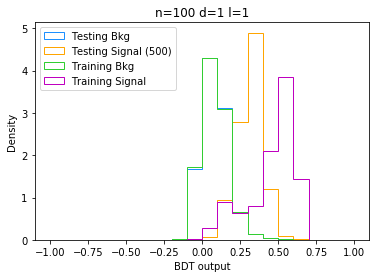

In [8]:
n_testing = 100
d_testing = 1
l_testing = [1]
    
bins = np.linspace(-1,1,20)

for i in l_testing:
    plt.figure()
    signif = test_BDT(n_testing, d_testing, i) 
    
    test_sig_final = signif[0]
    train_sig_final = signif[1]
    
    print(test_sig_final)
    print(train_sig_final)
    
 #   with open("Sig_GridSearch_1.txt", "a") as output:
#        output.write(str(test_sig_final) + '\n')
#        output.write(str(train_sig_final) + '\n')